In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Bending points
Given:
- edge (p1, p2)
- an (intersecting) obstacle:
  - a list containing a single point representing another location 
  - OR a list of points representing a polygonal obstacle

Returns:
- 4 points that bend around the given obstacle, connecting to the line

In [2]:
# the radius of a location, maximum line width in the graph?
r = 0.5
# the buffer around obstacles
BUFFER = 0.0
# bending distance
d_bend = 1

In [3]:
def vecAngle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))

def rMatrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)],
                     [np.sin(angle),  np.cos(angle)]])

# def ltr(edge):
#     edge = np.array(edge)
#     if edge[0][0] != edge[1][0]:
#         p1, s = [edge[0], False] if edge[0][0] < edge[1][0] else [edge[1], True]
#         p2, s = [edge[1], False] if edge[0][0] < edge[1][0] else [edge[0], True]
#     else:
#         p1, s = [edge[0], False] if edge[0][1] > edge[1][1] else [edge[1], True]
#         p2, s = [edge[1], False] if edge[0][1] > edge[1][1] else [edge[0], True]
#     return p1, p2, s

def dist(edge, obs):
    # p1, p2, _ = ltr(edge)
    p1, p2 = np.array(edge)
    if len(obs) == 1:  
        loc = obs[0]
        dp1 = np.linalg.norm(p1-loc)
        dp2 = np.linalg.norm(p2-loc)

        T = p1

        angle = vecAngle([1,0], p2-T)
        if (p2-T)[1] > 0:
            angle = -angle
        R = rMatrix(angle)

        p2_tr = np.matmul(R, p2-T)
        loc_tr = np.matmul(R, loc-T)

        dline = 9 ** 99

        if loc_tr[0] > 0 and loc_tr[0] < p2_tr[0]:
            dline = np.abs(loc_tr[1])
            
        return np.min([dp1, dp2, dline])
    else:
        min = 9 ** 99


        for pt in obs:
            min = np.min([min, dist(edge, [pt])])

        SLICES = int(np.linalg.norm(p1-p2) / (0.3 + BUFFER)) + 1
        for i in range(len(obs)-1):
            dir = np.array(p2-p1)
            for v in range(SLICES + 1):
                min = np.min([min, dist([obs[i], obs[i+1]], [p1 + (dir * (v/SLICES))])])

        return min


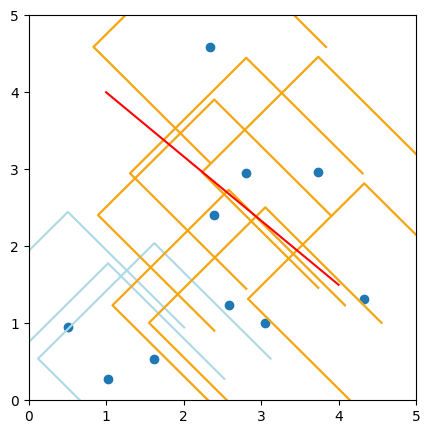

In [4]:
pts = np.random.rand(10, 2) * 5

# edge = np.array([[1,1.5], [4,4]])
edge = np.array([[1,4], [4,1.5]])

d = 1.5
obs = np.array([[pt+[d,0], pt+[0,d], pt-[d,0], pt-[0,d]] for pt in pts])

# filtered_pts = np.array([pt for pt in pts if (dist(edge, [pt]) < 0.3 + BUFFER)])
filtered_obs = np.array([o for o in obs if (dist(edge, o) < 0.5 + BUFFER)])

plt.figure(figsize=(5,5))
plt.axis([0, 5, 0, 5])

plt.scatter(pts.T[0], pts.T[1])
# plt.scatter(filtered_pts.T[0], filtered_pts.T[1])
for o in obs:
    plt.plot(o.T[0], o.T[1], c='lightblue')
for fo in filtered_obs:
    plt.plot(fo.T[0], fo.T[1], c='orange')

plt.plot(edge.T[0], edge.T[1], c='red')
plt.show()

In [5]:
# gets the bending points
# midpoints based on the axis aligned bounding box:
# only the corners with the smallest absolute value of y are taken
def bendpoints_r(obs, p2, lw):
    if len(obs) == 1:
        obs = obs[0]
        min_x = obs[0] - r - BUFFER
        max_x = obs[0] + r + BUFFER
        min_y = obs[1] - lw - r - BUFFER
        max_y = obs[1] + lw + r + BUFFER
    else: # obs.T[0] gets all x values, obs.T[1] the y values
        min_x = np.min(obs.T[0]) - BUFFER
        max_x = np.max(obs.T[0]) + BUFFER
        min_y = np.min(obs.T[1]) - lw - BUFFER
        max_y = np.max(obs.T[1]) + lw + BUFFER

    #get the midpoints
    midpoints = []
    for x in [min_x, max_x]:
        y = min_y if np.abs(min_y) <= np.abs(max_y) else max_y
        midpoints.append([x,y])
    midpoints = np.array(midpoints)

    
    #TODO: lock to edge start and end if they are 'too close'
    start = [np.max([min_x - d_bend, 0]), 0]
    end = [np.min([max_x + d_bend, p2[0]]), 0]

    bendpoints = np.array([start, midpoints[0], midpoints[1], end])

    return bendpoints

In [6]:
def bendpoints(edge, obs, lw):
    #to make sure they are easy to work with
    edge = np.array(edge)
    obs = np.array(obs)

    #choosing which point is the origin in the new coordinate system
    #leftmost in x or if equal x, the highest point
    # p1, p2, switched = ltr(edge)
    p1, p2 = edge

    '''TRANSLATION'''
    translation = p1 #the translation vector
    
    #translate
    # p1_t = p1 - translation #will be origin
    p2_t = p2 - translation
    obs_t = obs - translation

    '''ROTATION'''
    # standard vector angle formula: arccos(a dot b / (|a| * |b|))
    angle = vecAngle([1, 0], p2_t)
    # if the other endpoint of the edge is above the x axis the rotation needs to be negative
    if p2_t[1] > 0:
        angle = -angle
    
    # 2d rotation matrix construction: ((cos -sin), (sin cos))
    rotation = rMatrix(angle)

    p2_tr = np.matmul(rotation, p2_t)
    #rotate the obstacle into the new coordinate system
    obs_tr = np.matmul(rotation, obs_t.T).T
    

    '''OBSTACLE BENDING MIDPOINTS'''
    #get axis aligned bounding box in this coordinate system
    bend_tr = bendpoints_r(obs_tr, p2_tr, lw)

    #rotate and translate them back into the old coordinate system
    #transpose is inverse of a rotation matrix
    # bend = np.matmul(rotation.T, (bend_tr).T).T + translation

    bend = bend_tr

    # if switched:
    #     bend = bend[::-1]
    
    return bend

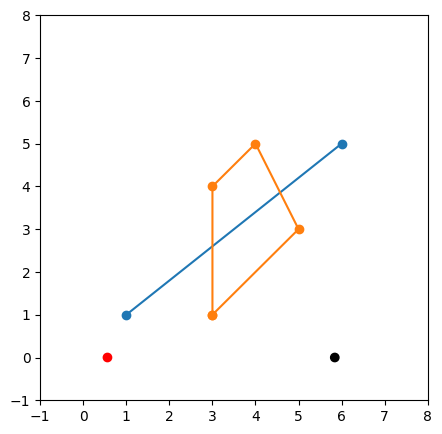

In [7]:
p1 = np.array([1,1])
p2 = np.array([6,5])
edge = np.array([p1, p2])
obstacle = np.array([[3,1], [5,3], [4,5], [3,4], [3,1]])
# obstacle = np.array([[3, 2.5]])

bend = bendpoints(edge, obstacle, 0.3)

plt.figure(figsize=(5,5))
plt.axis([-1, 8, -1, 8])

plt.plot(edge.T[0], edge.T[1])
plt.scatter(edge.T[0], edge.T[1])

plt.plot(obstacle.T[0], obstacle.T[1])
plt.scatter(obstacle.T[0], obstacle.T[1])

# plt.plot(triangle.T[0], triangle.T[1])
plt.scatter(bend.T[0], bend.T[1], c=['red', 'green', 'blue', 'black'])

plt.show()


# Making Edge Bends Matrix
Given:
- Sorted sequences by weight
- dictionary of locations
- list of obstacles

Returns:
- locations × locations matrix that define how the edge between a location pair looks

```
detection:
    for each edge (not hyperedge?) sorted high to low by weight
        if edge already checked: skip
        for each obstacle
            if obstacle outside of edge-aligned bounding box of the edge: skip
            else if 
                if obstacle is another location
                    if distance from location to edge (minus radius around location) is less than some threshold
                        bend with the edge and obstacle in mind
                if obstacle is some polygon
                    if distance from closest polygon point to edge is less than some threshold
                        bend with the edge and obstacle in mind

bending:
    find the bounding box aligned with the edge:
        (perform translations and rotations)
        bounding box is lowest and highest x and y of the obstacle
        (for locations, the coordinates +&- radius)
        the line goes through two corners of the bounding box: the one with smallest |y| in the rotated scenario```

In [8]:
#INPUT
sequences = [(["S", "A", "D"], 1000), (["S", "B", "D"], 700), (["S", "B", "C"], 500), (["S", "A", "C"], 200)]
name2coord = {"S": [0,0], "A": [4,4], "B": [4,-.5], "C": [3.5, -4], "D": [6,1]}
obstacles = [[[4, -1.5]], [[3.5, -3]], [[2,2], [3,1], [4,2], [2,2]], [[1,1.5]]]
# for loc in list(name2coord.values()):
#     obstacles.append([loc])

In [9]:
# the radius of a location, maximum line width in the graph?
r = 0.3
# the buffer around obstacles
BUFFER = 0.1
# bending distance
d_bend = 0.5

In [10]:
name2idx = dict(zip(name2coord.keys(), list(range(len(name2coord.keys())))))

bendmatrix = np.empty((len(name2coord.keys()), len(name2coord.keys())), dtype=list)
print(bendmatrix)

[[None None None None None]
 [None None None None None]
 [None None None None None]
 [None None None None None]
 [None None None None None]]


In [11]:
for seq in sequences:
    for i in range(len(seq[0])-1):
        src = seq[0][i]
        trg = seq[0][i+1]

        #if there already exists a bendmatrix entry, skip
        if type(bendmatrix[name2idx[src]][name2idx[trg]]) == list:
            continue
        
        # bendmatrix[name2idx[src]][name2idx[trg]] = []
        # bendmatrix[name2idx[trg]][name2idx[src]] = []

        edge = [name2coord[src], name2coord[trg]]
        lw = seq[1]/1000 #SCALE HERE
        
        other_loc = [[name2coord[loc]] for loc in list(name2coord.keys()) if loc != src and loc != trg]
        avoid = [*obstacles, *other_loc]

        st = []
        # ts = []

        for obs in avoid:
            if dist(edge, obs) < lw + BUFFER:
                bend = bendpoints(edge, obs, lw)
                #gather all bends
                st.extend( [bend] ) 
        
        #sort the bends
        st.sort(key = lambda x : x[0][0])
        
        # turn list of bends into list of points
        acc = []
        for bend in st:
            for pt in bend:
                acc.append(pt)
        st = np.array(acc)

        # make sure we dont have p4 and p1 of two bends overlapping
        for i in range(3, len(st)-2, 4):
            if st[i][0] > st[i+1][0]:
                st[i] = st[i-1]
                st[i+1] = st[i+2]

        # T, p2, switched = ltr(edge)
        T, p2 = np.array(edge)
        angle = vecAngle([1,0], p2-T)
        if (p2-T)[1] > 0:
            angle = -angle
        R = rMatrix(angle)

        # print(st)

        if list(st) != []:
            line = np.matmul(R.T, st.T).T + T
        else:
            line = st

        # if switched:
        #     line = line[::-1]

        bendmatrix[name2idx[src]][name2idx[trg]] = line
        bendmatrix[name2idx[trg]][name2idx[src]] = line[::-1]

In [12]:
bendmatrix

array([[None, array([[1.57573593, 1.57573593],
                     [1.71715729, 2.14142136],
                     [2.85857864, 3.28284271],
                     [3.42426407, 3.42426407]]),
        array([], dtype=float64), None, None],
       [array([[3.42426407, 3.42426407],
               [2.85857864, 3.28284271],
               [1.71715729, 2.14142136],
               [1.57573593, 1.57573593]]), None, None,
        array([[ 3.91291335,  2.60661365],
               [ 4.3056536 ,  2.08109177],
               [ 4.22703009,  0.8231155 ],
               [ 4.22703009,  0.8231155 ],
               [ 3.42611977, -0.063352  ],
               [ 3.42611977, -0.063352  ],
               [ 3.37621714, -0.86179406],
               [ 3.6637039 , -1.38073759],
               [ 3.61839727, -2.10564373],
               [ 4.12378286, -2.63820594],
               [ 4.07388023, -3.436648  ],
               [ 3.50611635, -3.90213837]]), array([], dtype=float64)],
       [array([], dtype=float64), None, 

In [15]:
bendmatrix[name2idx['S']][name2idx['A']]

array([[1.57573593, 1.57573593],
       [1.71715729, 2.14142136],
       [2.85857864, 3.28284271],
       [3.42426407, 3.42426407]])

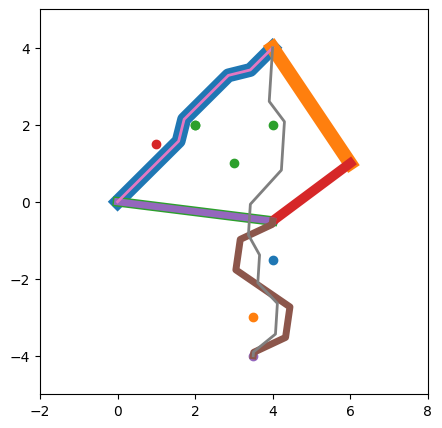

In [13]:
plt.figure(figsize=(5,5))
plt.axis([-2, 8, -5, 5])

loc_xs = np.array(list(name2coord.values())).T[0]
loc_ys = np.array(list(name2coord.values())).T[1]

for obs in obstacles:
    plt.scatter(np.array(obs).T[0], np.array(obs).T[1])

plt.scatter(loc_xs, loc_ys)

for seq in sequences:
    for i in range(len(seq[0])-1):
        src = seq[0][i]
        trg = seq[0][i+1]

        bend = bendmatrix[name2idx[src]][name2idx[trg]]

        line = np.array([name2coord[src], *bend, name2coord[trg]])

        plt.plot(line.T[0], line.T[1], linewidth=seq[1]/100)

plt.show()